# Réseau d'accès radio TP
Lucas Hocquette - Quentin Goulas

# Exercice 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 1
def sample_users(K,R):
    v = np.random.uniform(low=0,high=R**2,size=K)
    theta = np.random.uniform(low=0,high=2*np.pi,size=K)
    r = np.sqrt(v)
    x,y = r*np.cos(theta), r*np.sin(theta)
    return x,y

In [3]:
# 2
r = 1
W = 3.84*10**6
theta = 0.4
sigma2 = 10**(-104/10)*1e-3
P = 10**(40/10)*1e-3

def measure_achievement_ratio(K,R,gamma,n_avg=1):
    x,y = sample_users(K,r)
    d = np.sqrt(x**2+y**2)
    L = -128.1 - 37.6*np.log10(d)
    l = 10**(L/10)
    history = np.zeros(n_avg)
    for i in range(n_avg):
        h = np.random.exponential(0.5,K)
        g = l*h
        p = P/K
        SINR = W/R*p*g/(theta*(K-1)*p*g+sigma2)
        history[i] = np.mean(SINR>=gamma)

    return history

print(f'The percentage of users for which the decoding condition is satisified is : {measure_achievement_ratio(20,32*1e3,10**(7/10))[0]*100}%')

The percentage of users for which the decoding condition is satisified is : 95.0%


In [59]:
# 3 and 4

achievement_ratio = measure_achievement_ratio(20,32*1e3,10**(7/10),100)
print(f'delta = {np.mean(achievement_ratio)*100}%')

delta = 98.1%


[1.         1.         0.99666667 0.9975     0.998      0.99166667
 0.99285714 0.99125    0.99333333 0.987      0.99181818 0.99333333
 0.99076923 0.98571429 0.98       0.991875   0.98235294 0.98166667
 0.98263158 0.9825     0.98238095 0.975      0.98217391 0.96333333
 0.9764     0.96961538 0.96444444 0.96892857 0.96241379 0.94666667
 0.96548387 0.939375   0.94606061 0.95647059 0.95428571 0.93694444
 0.94675676 0.925      0.92820513 0.91475    0.88170732 0.90666667
 0.88116279 0.88159091 0.89644444 0.84934783 0.87574468 0.893125
 0.8344898  0.8216     0.80588235 0.77134615 0.75811321 0.79
 0.69036364 0.69446429 0.61912281 0.44827586 0.42101695 0.23133333
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.       

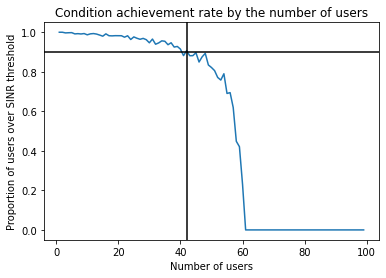

In [57]:
# 5

K_values = np.array(range(1,100))
deltas = np.zeros(len(K_values))

for i,K in enumerate(K_values) :
    ach_rat = measure_achievement_ratio(K,32*1e3,10**(7/10),100)
    deltas[i] = np.mean(ach_rat)

print(deltas)
print(f'The maximum number of users on the network is {K_values[np.sum(deltas>=0.9)]}')

plt.plot(K_values,deltas)
plt.title('Condition achievement rate by the number of users')
plt.xlabel('Number of users')
plt.ylabel('Proportion of users over SINR threshold')
plt.axhline(0.9,color='0')
plt.axvline(K_values[np.sum(deltas>=0.9)],color='0')
plt.show()

# Exercice 2

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
print(np.__version__)

1.22.4


$$ 
F = \begin{pmatrix} 
        0, \frac{g_2}{R_1g_1}, \cdots, \frac{g_k}{R_1g_1} \\
        \frac{g_1}{R_2g_2}, 0, \ddots, \vdots \\
        \vdots, \ddots, \ddots, \vdots \\
        \frac{g_1}{R_kg_k}, \cdots, \cdots, 0
    \end{pmatrix}       
$$

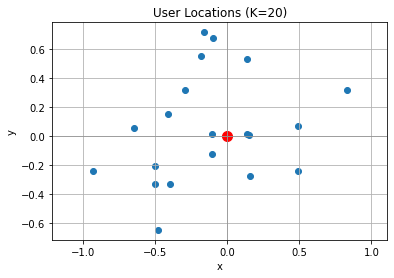

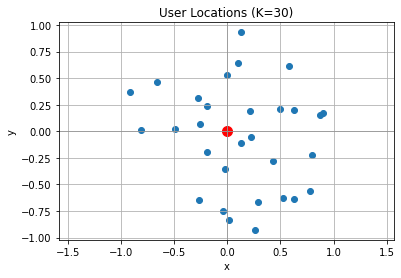

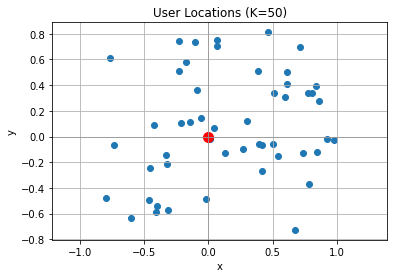

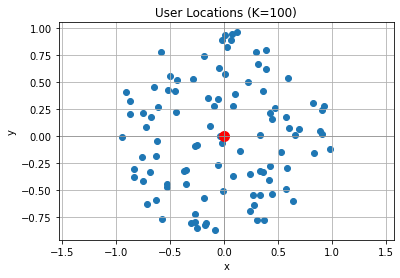

In [10]:
# 1.a

def sample_users(K,R):
    v = np.random.uniform(low=0,high=R**2,size=K)
    theta = np.random.uniform(low=0,high=2*np.pi,size=K)
    r = np.sqrt(v)
    x,y = r*np.cos(theta), r*np.sin(theta)
    return x,y

for K in [20,30,50,100]:
    # Example usage
    R = 1
    x, y = sample_users(K, R)

    plt.scatter(x, y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f"User Locations (K={K})")
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.axis('equal')
    plt.gca().set_aspect('equal')
    plt.grid(True)
    plt.scatter(0, 0, color='red', s=100)
    plt.show()

In [43]:
# 1.b
# K = np.array([20, 30, 50, 100],dtype=np.int32)
K = np.array(range(10,100,2), dtype=np.int32)
R = 1
r1,r2 = 15*1e3,32*1e3
W = 3.84*10**6
theta = 0.4
gamma1, gamma2  = 10**(5/10), 10**(7/10)
Rho = np.array([])

def generate_F(k,R,r1,r2,gamma1,gamma2,W,theta):
    x,y = sample_users(k,R)
    r = np.concatenate((r1*np.ones(k//2),r2*np.ones(k//2)))
    gamma = np.concatenate((gamma1*np.ones(k//2),gamma2*np.ones(k//2)))
    lamda = 0.5
    h = np.random.exponential(1/lamda,k)
    d = np.sqrt(x**2+y**2)
    L = -128.1 - 37.6*np.log10(d)
    l = 10**(L/10)
    g = l*h
    G1,G2 = np.meshgrid(gamma*r*g,g)
    F = (theta/W)*G1 / G2
    F[np.eye(k,dtype=bool)] = 0
    return F, r, gamma, g

for k in K:
    F,_,_,_ = generate_F(k,R,r1,r2,gamma1,gamma2,W,theta)
    rho = np.max(np.abs(np.linalg.eigvals(F)))
    Rho = np.append(Rho,rho)

Kmax = np.max(K[Rho<1])
print(Kmax)

92


[28.16665678  6.86250169 20.71464779 18.84900969  5.55326503 20.26449124
 18.5940011  22.53251589 10.8578652   5.84853617 15.24183855 30.84545035
 10.5792318  33.70498719 29.24888039 17.25597702 16.96352345 18.71285413
 16.87350927 20.90320268 19.08188648 16.72779185 24.40954399 15.50125749
 26.33456371 17.77436252 22.1659222  16.01064378 19.96822014 25.66662887
 30.59317692 35.32767581 18.90044914 17.32921501 17.94490598 13.92232916
  9.26279138  9.88947905 10.04367335 25.50658171 22.76623012 16.83294348
  5.8447057  20.45764339 28.15794973 17.09403185 20.92933376  8.15692142
 22.09419991 22.58831    20.75625269 32.90413606 23.3908391  23.04813658
 20.5434783  28.44204695 23.80893325 13.43379353 11.54665306 21.40922606
 23.7260069  14.92430548 15.09423377  5.16109012 21.82039109 23.00013506
 -3.03496525 10.79476481 25.52802375  6.17862929 -9.94205266 23.84591141
 24.64791867 22.59839311 17.33067306 26.95989872 30.23779763 23.22757386
 24.90262049 16.1683794  27.01378274  6.01056962 18

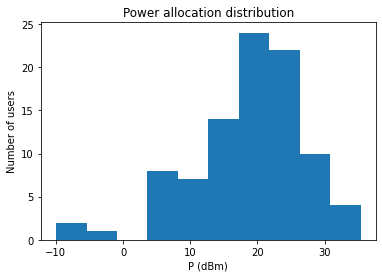

In [44]:

#1.c
k = Kmax

x,y = sample_users(k,R)
r = np.concatenate((r1*np.ones(k//2),r2*np.ones(k//2)))
gamma = np.concatenate((gamma1*np.ones(k//2),gamma2*np.ones(k//2)))
lamda = 0.5
h = np.ones(k)
h = np.random.exponential(1/lamda,k)
d = np.sqrt(x**2+y**2)
L = -128.1 - 37.6*np.log10(d)
l = 10**(L/10)
g = l*h
G1,G2 = np.meshgrid(gamma*r*g,g)
F = (theta/W)*G1 / G2
F[np.eye(k,dtype=bool)] = 0

sigma2 = 10**(-104/10)/1000
b = sigma2*(1/(3.84*10**6))*r*gamma/g
P =  np.linalg.inv(np.eye(k) - F)@b

print(10*np.log10(P*1000)) # display the power allocation in dBm

def SINR(W,R,P,G,theta,sigma2):
    alpha = W/R
    pg = P*G
    p,_ = np.meshgrid(P,P)
    p[np.eye(len(p),dtype=bool)] = 0
    sm = np.sum(p,axis=1)*G
    return alpha*pg/(theta*sm+sigma2)

plt.hist(10*np.log10(P*1000))
plt.title('Power allocation distribution')
plt.ylabel('Number of users')
plt.xlabel('P (dBm)')
plt.show()

k=10, num_iteration=4
k=12, num_iteration=5
k=14, num_iteration=6
k=16, num_iteration=4
k=18, num_iteration=3
k=20, num_iteration=7
k=22, num_iteration=5
k=24, num_iteration=4
k=26, num_iteration=6
k=28, num_iteration=7
k=30, num_iteration=6
k=32, num_iteration=13
k=34, num_iteration=9
k=36, num_iteration=10
k=38, num_iteration=9
k=40, num_iteration=10
k=42, num_iteration=11
k=44, num_iteration=13
k=46, num_iteration=11
k=48, num_iteration=11
k=50, num_iteration=16
k=52, num_iteration=20
k=54, num_iteration=11
k=56, num_iteration=19
k=58, num_iteration=14
k=60, num_iteration=19
k=62, num_iteration=16
k=64, num_iteration=13
k=66, num_iteration=19
k=68, num_iteration=19
k=70, num_iteration=23
k=72, num_iteration=38
k=74, num_iteration=27
k=76, num_iteration=51
k=78, num_iteration=33
k=80, num_iteration=41
k=82, num_iteration=42
k=84, num_iteration=31
k=86, num_iteration=54
k=88, num_iteration=105
k=90, num_iteration=125


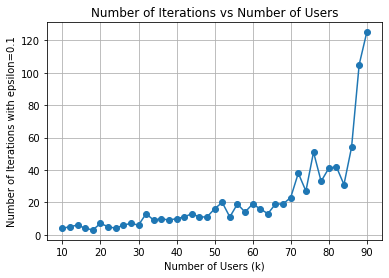

In [45]:
#1.d
K_list = np.array(range(10,Kmax,2), dtype=np.uint32)
epsilon = 0.1
iteration_list = np.zeros(len(K_list))

for idx in range(len(K_list)):
    k = K_list[idx]
    p = np.ones(k)
    new_p = np.ones(k)*0.1
    num_iteration = 0
    _, r, gamma, g = generate_F(k,R,r1,r2,gamma1,gamma2,W,theta)
    while not np.all(np.abs(p - new_p) < epsilon):
        p = new_p
        pg = p*g
        pg1,_ = np.meshgrid(pg,pg)
        pg1[np.eye(len(pg),dtype=bool)] = 0
        sm = np.sum(pg1,axis=1)
        new_p = (r*gamma*(theta*sm + sigma2))/(W*g)
        num_iteration += 1
    iteration_list[idx] = num_iteration
    print(f"k={k}, num_iteration={num_iteration}")

plt.plot(K_list, iteration_list, marker='o')
plt.xlabel('Number of Users (k)')
plt.ylabel(f'Number of Iterations with epsilon={epsilon}')
plt.title('Number of Iterations vs Number of Users')
plt.grid(True)
plt.show()
    

[2567. 1859. 1473. 1227. 1055.  929.  831.  752.  689.  635.  590.  551.
  518.  488.  462.  438.  417.  398.]


Text(0, 0.5, 'Number of iterations')

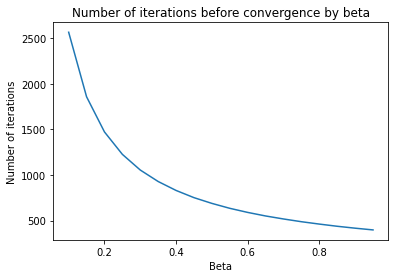

In [46]:
# 1.e

def iterativeE(gamma,beta,tol,seed):
    p=seed.copy()
    p_old = np.inf*np.ones_like(p)
    iter = 0
    while np.sum(abs(p-p_old))>=tol:
        p_old = p.copy()
        sinr = SINR(W,r,p,g,theta,sigma2)
        p = (1-beta)*p + beta*gamma/sinr*p
        iter +=1
    return p, iter

Beta = np.arange(0.1,1,0.05)
Niter = np.zeros_like(Beta)
_, r, gamma, g = generate_F(Kmax,R,r1,r2,gamma1,gamma2,W,theta)

seed = np.ones(Kmax)
for b in range(len(Beta)):
    p,iter = iterativeE(gamma,Beta[b],1e-3,seed)
    Niter[b] = iter

print(Niter)

plt.plot(Beta,Niter)
plt.title('Number of iterations before convergence by beta')
plt.xlabel('Beta')
plt.ylabel('Number of iterations')

In [47]:
# 1.f

def iterativeF(gamma,alpha,tol,seed,maxIter):
    p = seed.copy()
    p_old = np.inf*np.ones_like(p)
    iter = 0
    while (np.sum(abs(p-p_old))>=tol) & (iter<maxIter):
        p_old = p.copy()
        sinr = SINR(W,r,p,g,theta,sigma2)
        p[sinr<gamma] = alpha*p_old[sinr<gamma]
        p[sinr>gamma] = p_old[sinr>gamma]/alpha
        iter +=1
    return p, iter

Alpha = 10**(np.linspace(0.25,1.5,7)/10)
Niter = np.zeros_like(Alpha)
_, r, gamma, g = generate_F(Kmax,R,r1,r2,gamma1,gamma2,W,theta)

seed = np.ones(Kmax)
for a in range(len(Alpha)):
    p,iter = iterativeF(gamma,Alpha[a],1e-3,seed,5e3)
    Niter[a] = iter

print(Niter)

[5000. 5000. 5000. 5000. 5000. 5000. 5000.]


In [60]:
# 1.g
def iterativeG(gamma,alpha,tol,maxIter):
    p = np.ones(Kmax)
    p_old = np.inf*np.ones_like(p)
    iter = 0
    while (np.sum(abs(p-p_old))/Kmax>=tol) & (iter<maxIter):
        p_old = np.copy(p)
        sinr = SINR(W,r,p,g,theta,sigma2)
        p[sinr > alpha*gamma*p_old] = p_old[sinr > alpha*gamma*p_old]/alpha
        p[sinr < gamma*alpha**(-1)] = p_old[sinr < gamma*alpha**(-1)]*alpha
        iter += 1
    return p, iter

Alpha = 10**(np.linspace(0.25,1.5,7)/10)
#Alpha = [10**(0.25/10), 10**(0.25/10), 10**(0.25/10)]
Niter = np.zeros_like(Alpha)
_, r, gamma, g = generate_F(Kmax,R,r1,r2,gamma1,gamma2,W,theta)
epsilon = 5e-3

for a in range(len(Alpha)):
    p_alpha,iter = iterativeG(gamma,Alpha[a],epsilon,5e3)
    Niter[a] = iter

print(Niter)

[5000. 5000. 5000. 5000. 5000. 5000. 5000.]


[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
[0.00108582 0.00064746 0.00234666 0.00363168 0.0011197  0.00317839
 0.00247856 0.00200685 0.00372026 0.00263357]


Text(0, 0.5, 'Proportion of users satisfying SINR condition')

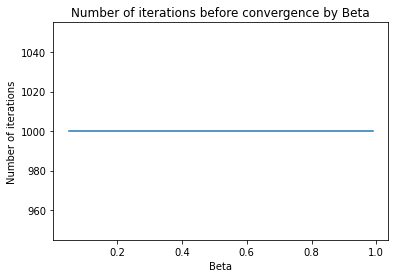

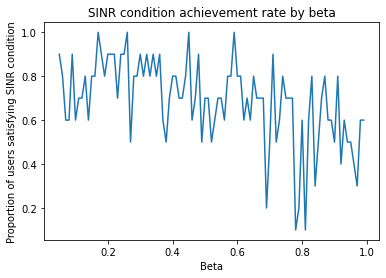

In [53]:
# 2.a


def generate_F2(k,R,r1,r2,gamma1,gamma2,W,theta):
    x,y = sample_users(k,R)
    r = np.concatenate((r1*np.ones(k//2),r2*np.ones(k//2)))
    gamma = np.concatenate((gamma1*np.ones(k//2),gamma2*np.ones(k//2)))
    d = np.sqrt(x**2+y**2)
    L = -128.1 - 37.6*np.log10(d)
    l = 10**(L/10)
    return r, gamma, l

def iterativeE(gamma,beta,tol,seed,k,l,r,lim_iteration):
    p=seed.copy()
    p_old = np.inf*np.ones_like(p)
    iter = 0
    lamda = 0.5
    while lim_iteration > iter:

        h = np.random.exponential(1/lamda,k)
        g = l*h

        p_old = p.copy()
        sinr = SINR(W,r,p,g,theta,sigma2)
        p = ((1-beta)*p + p*beta*gamma/sinr)
        iter +=1
        
    return p, iter, sinr

lim_iteration = 1000
K = 10
Beta = np.arange(0.05,1,0.01)
Niter = np.zeros_like(Beta)
ach_rat = np.zeros_like(Beta)
r, gamma,l = generate_F2(K,R,r1,r2,gamma1,gamma2,W,theta)

seed = np.ones(K)
for b in range(len(Beta)):
    p,iter,sinr = iterativeE(gamma,Beta[b],1e-3,seed,K,l,r,lim_iteration)
    Niter[b] = iter
    ach_rat[b] = np.mean(sinr>=gamma)

plt.figure()
plt.plot(Beta,ach_rat)
plt.title('SINR condition achievement rate by beta')
plt.xlabel('Beta')
plt.ylabel('Proportion of users satisfying SINR condition')

# Exercice 3

In [54]:
# 1)

r = 1
W = 3.84*10**6
theta = 0.4
sigma2 = 10**(-104/10)*1e-3
P = 10**(40/10)*1e-3

def measure_achievement_ratio(K,R,gamma,n_avg=1):
    x,y = sample_users(K,r)
    d = np.sqrt(x**2+y**2)
    L = -128.1 - 37.6*np.log10(d)
    l = 10**(L/10)
    history = np.zeros((n_avg,1))
    for i in range(n_avg):
        h = np.random.exponential(0.5,K)
        g = l*h
        p = P/K
        SINR = W/R*p*g/(theta*(K-1)*p*g+sigma2)
        history[i] = np.mean(SINR>=gamma)

    return history

K_values = np.array(range(1,100))
deltas = np.zeros(len(K_values))

for i,K in enumerate(K_values) :
    ach_rat = measure_achievement_ratio(K,240*1e3,10**(10/10),100)
    deltas[i] = np.mean(ach_rat)

print(deltas)
print(f'The maximum number of users on the network is {K_values[np.sum(deltas>=0.9)]}')

[0.95   0.95   0.97   0.9275 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
The maximum number of users on the network is 5


In [56]:
# 2)

T = 1000
I = 50
gamma_i = 10**(10/10)
R_i = 240e3
L = 16                  # = W/R_i
P = 10**(40/10)*1e-3
K_list = [10, 20, 30, 40]
radius = 1
lamda = 0.5
sigma2 = 10**(-104/10)*1e-3

for K in K_list:
    try_averages = np.zeros(I)
    for idx in range(I):
        # Generate K users
        x, y = sample_users(K, radius)
        # Compute distance and pathloss effect
        d = np.sqrt(x**2+y**2)
        L = -128.1 - 37.6*np.log10(d)
        l = 10**(L/10)
        Average_rates = np.zeros(K)

        for t in range(T):
            h = np.random.exponential(1/lamda,K)
            g = l*h
            SNR_base = P*g/sigma2
            SNR = SNR_base.copy()
            C = np.ones(K)
            current_rates = np.zeros(K)
            proportional_fairness = np.zeros(K)

            for i in range(K):
                while SNR[i] > gamma_i and C[i] < 15:
                    SNR[i] = SNR_base[i]/C[i]
                    C[i] += 1
                # print(f"SNR[i] = {SNR[i]} and gamm_i = {gamma_i}")

                current_rates[i] = C[i] * R_i
                if Average_rates[i] != 0:
                    proportional_fairness[i] = np.argmax(current_rates[i]/Average_rates[i])
                else:
                    proportional_fairness[i] = np.inf
            selected_user = np.argmax(proportional_fairness)
            Average_rates[selected_user] += -(1/(t+1))*Average_rates[selected_user] + current_rates[selected_user]/(t+1)
            Average_rates[range(K) != selected_user] -= Average_rates[range(K) != selected_user]/(t+1)
        try_averages[idx] = np.mean(Average_rates)
    print(f"K={K}, Average Rate={np.mean(try_averages):.2f}, Standard Deviation={np.std(try_averages):.2f}")

K=10, Average Rate=302435.04, Standard Deviation=55886.00
K=20, Average Rate=145715.76, Standard Deviation=25712.58
K=30, Average Rate=98592.00, Standard Deviation=17455.12
K=40, Average Rate=71969.16, Standard Deviation=14026.13
